## GENERAL SETUP

In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# load local version of skaro, before pip installed version, for debugging
import os
import pathlib
import sys

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from skaro.planets import PlanetModel
from skaro.utilities.dataframe import rename_labels
from skaro.visualization.visualization_utils import (
    FigureProcessor,
    adjust_legend,
    get_palette,
    set_plot_defaults,
)

## PLOT SETUP

In [39]:
set_plot_defaults()

figure_subdirectory = "Original_NGPPS_sample"
save = True

## ORIGINAL SAMPLE (HOST STAR MASS = 1)

### Setup Variables and Planet Model

In [40]:
num_embryos = 50
host_star_mass = 1

planet_model = PlanetModel(num_embryos)

population_id = planet_model.get_population_id(num_embryos, host_star_mass)

categories = [
    category
    for category in planet_model.categories
    if category not in ["Dwarf", "D-Burner"]
]

### Recreate Original Sample (needs neighbors=1, to actually re-create original data)

In [41]:
original_variables = planet_model.get_systems(population_id).variables
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    return_full=True,
    neighbors=1,
)

# change labels for plotting
original_sample, labels = rename_labels(original_sample)

### Pair Plot (variations for one planet category with variables)

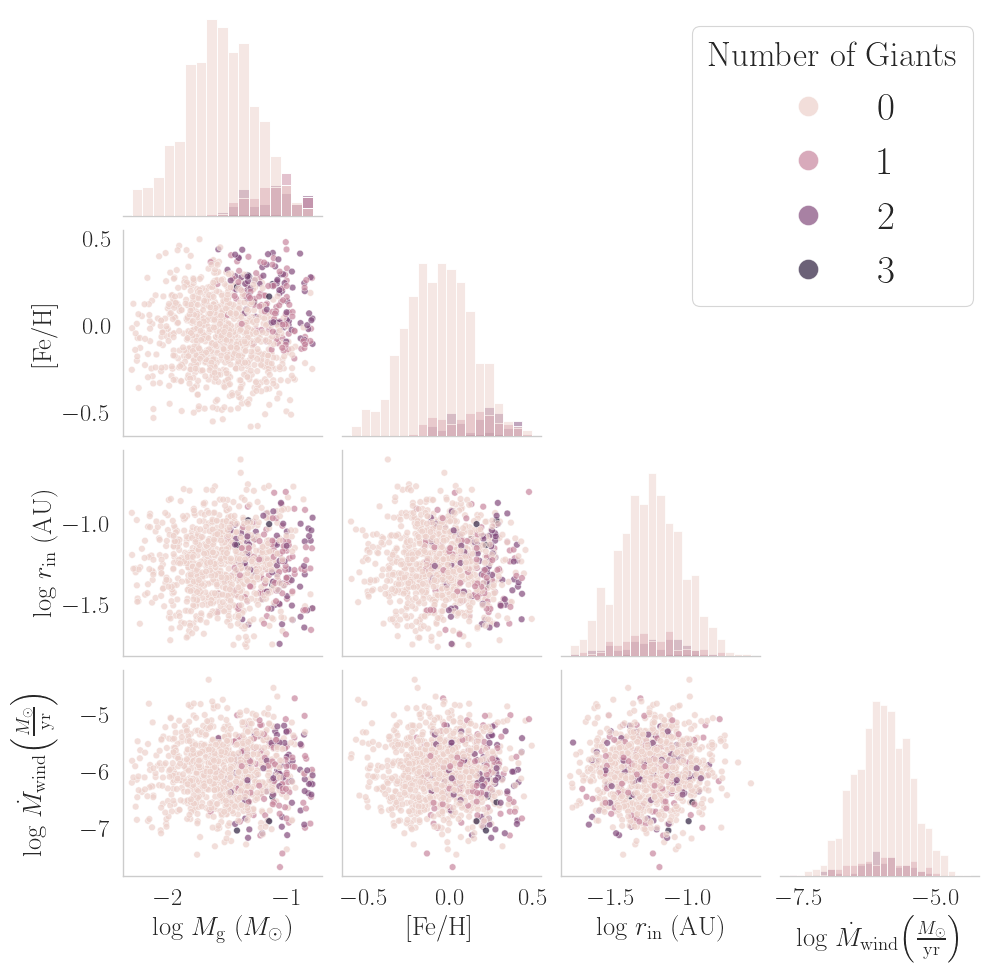

In [42]:
planet_type = "Giant"
with sns.plotting_context("paper", font_scale=2):
    pair_plot = sns.pairplot(
        original_sample.drop(
            columns=[
                "age",
                "out_of_bounds_flag",
                *[c for c in categories if c != planet_type],
            ]
        ),
        hue=planet_type,
        diag_kind="hist",
        corner=True,
        palette=get_palette(n_colors=4),
        plot_kws={"alpha": 0.7},
    )

sns.move_legend(
    pair_plot,
    "upper right",
    bbox_to_anchor=(0.9, 0.98),
    markerscale=3,
    title="Number of Giants",
    title_fontsize=25,
    frameon=True,
)

FigureProcessor(pair_plot.figure).save(
    "pairplot.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

### Correlation plot between Planet Types and Variables (Kendall Tau correlation coefficent)

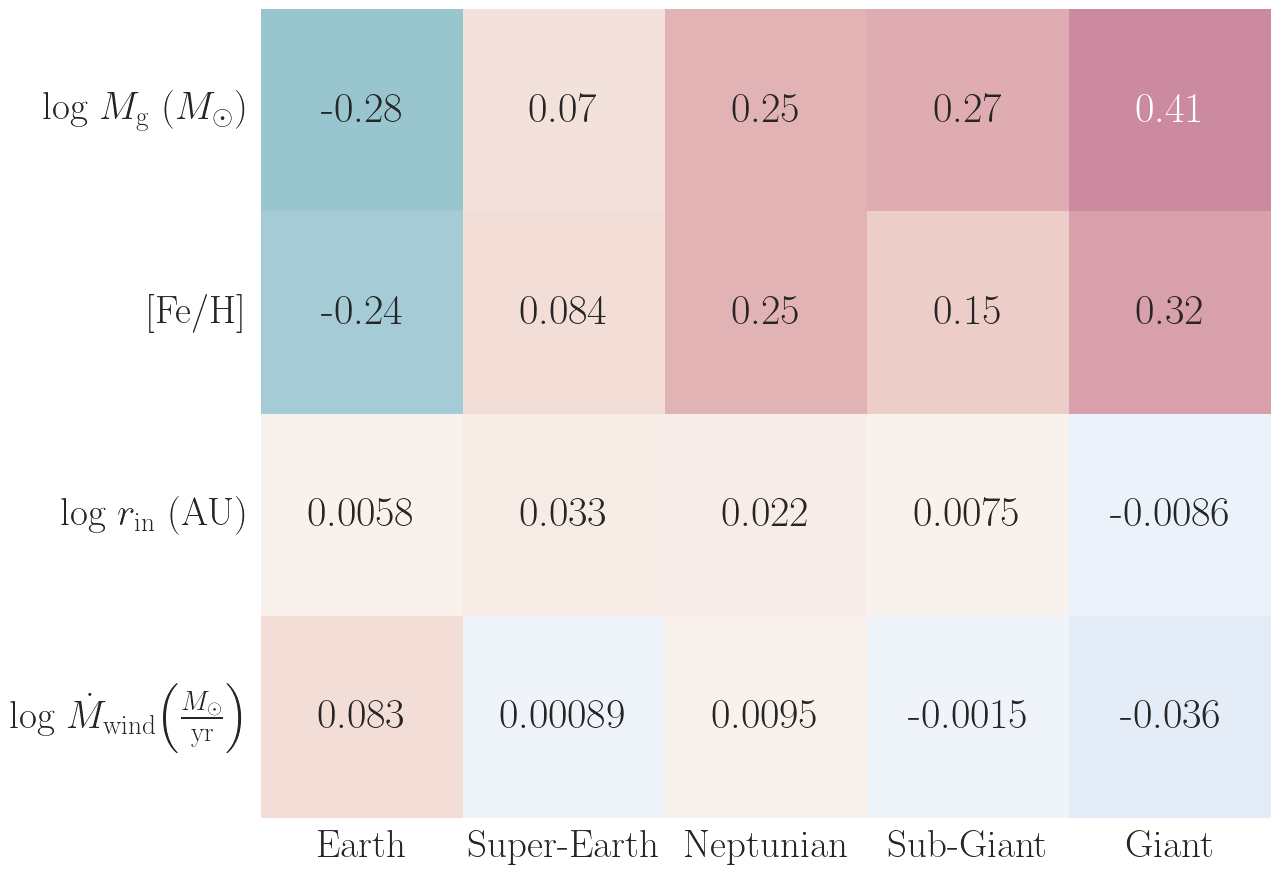

In [43]:
correlation_matrix = original_sample.corr(method="kendall").drop(
    columns=["age", "out_of_bounds_flag", *labels.values()],
    index=["age", "out_of_bounds_flag", *categories],
)
correlation_plot = sns.heatmap(
    correlation_matrix,
    vmin=-1,
    vmax=1,
    square=True,
    annot=True,
    cbar=False,
    cmap=get_palette(diverging=True, as_cmap=True),
)
FigureProcessor(correlation_plot.figure).save(
    "correlation_matrix.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

### Correlation plot between different planet types

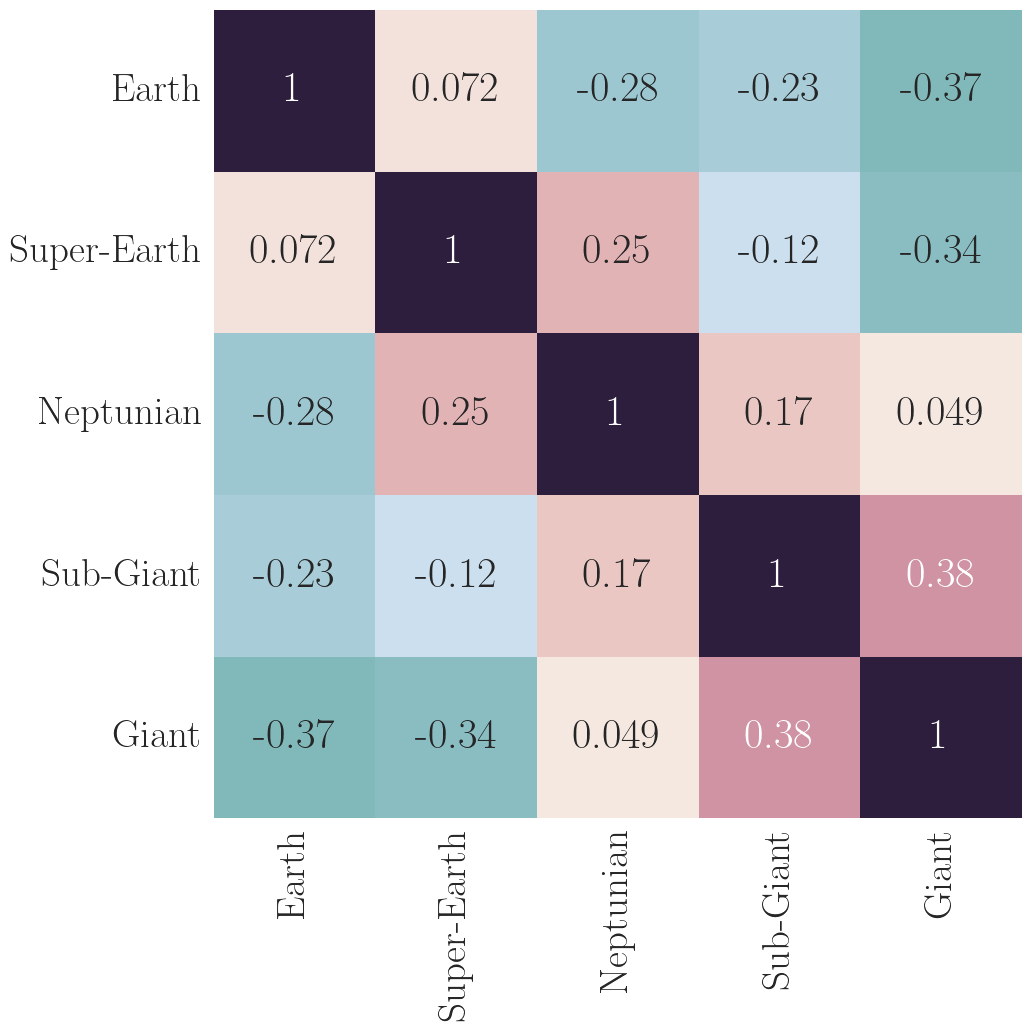

In [44]:
correlation_matrix = original_sample.corr(method="kendall").drop(
    columns=["age", "out_of_bounds_flag", *labels.values()],
    index=["age", "out_of_bounds_flag", *labels.values()],
)
correlation_plot = sns.heatmap(
    correlation_matrix,
    vmin=-1,
    vmax=1,
    square=True,
    annot=True,
    cbar=False,
    cmap=get_palette(diverging=True, as_cmap=True),
)
FigureProcessor(correlation_plot.figure).save(
    "correlation_matrix_planet_types.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

### Changes of Number of Planets With Initial Embryo Count

In [46]:
num_embryo_list = [10, 20, 50, 100]

results_embryos = {}
for num in num_embryo_list:
    planet_model = PlanetModel(num)
    results_embryos[num] = (
        planet_model.prediction(
            categories,
            host_star_mass,
            variables=original_variables,
            neighbors=1,
        ).sum()
        / original_variables.shape[0]
    )

results_embryos = pd.DataFrame(results_embryos).T
results_embryos = results_embryos.reset_index().rename(
    {"index": "Number of Embryos"}, axis="columns"
)

results_embryos_long_format = results_embryos.melt(
    id_vars="Number of Embryos",
    var_name="Category",
    value_name="Occurrence Rate",
)

/tmp/ipykernel_95969/282277728.py:2: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  embryo_barplot = sns.barplot(


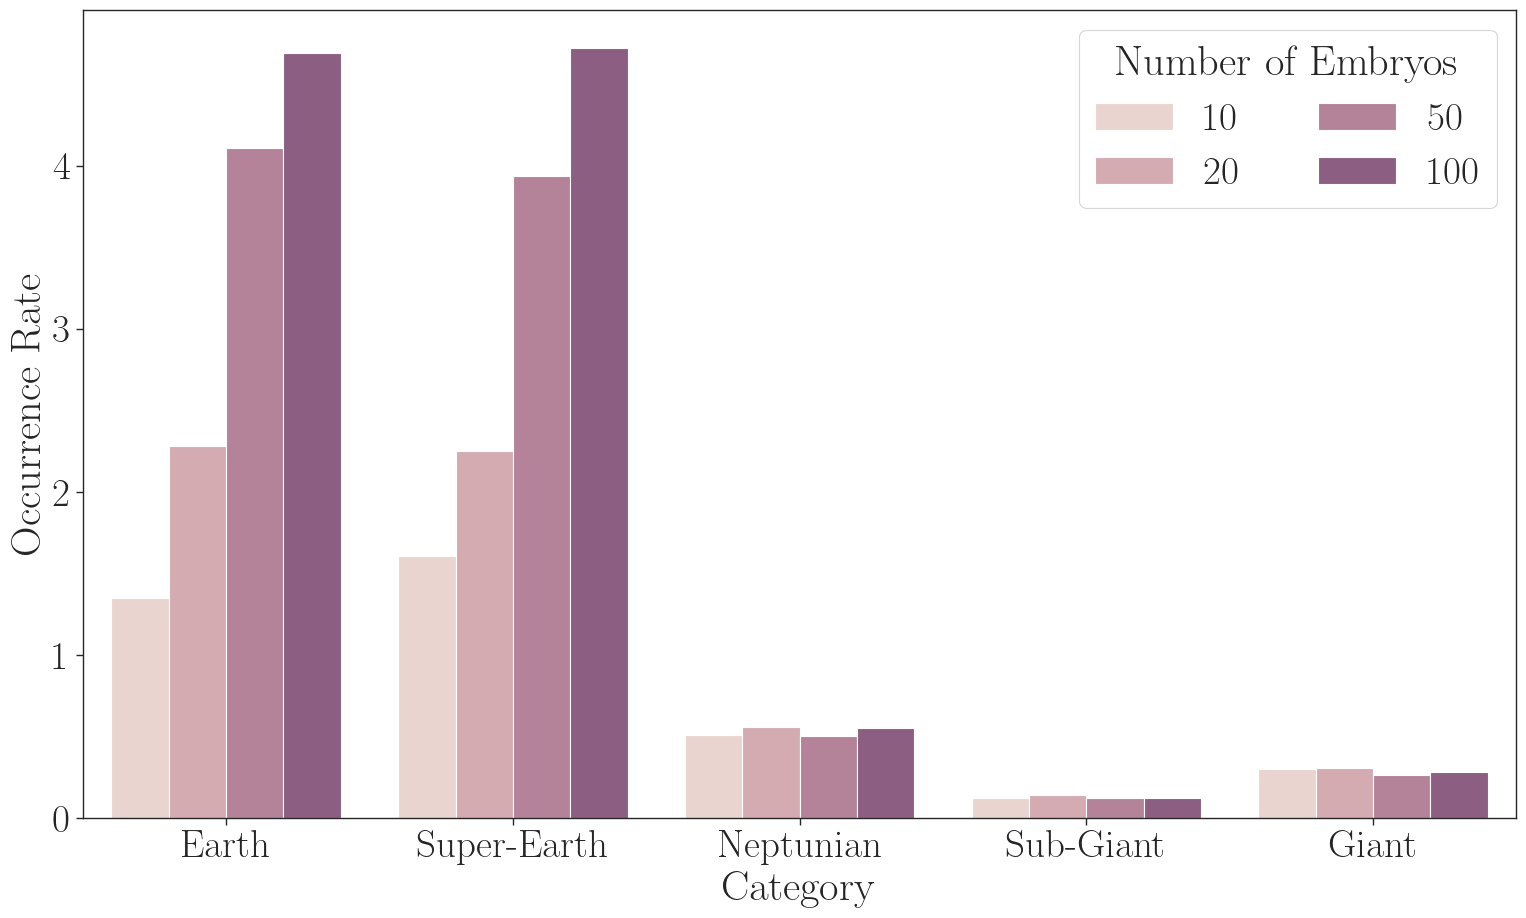

In [47]:
with sns.axes_style("ticks"):
    embryo_barplot = sns.barplot(
        data=results_embryos_long_format,
        x="Category",
        y="Occurrence Rate",
        hue="Number of Embryos",
        palette=get_palette(),
    )
# adjust legend
embryo_barplot = adjust_legend(
    embryo_barplot,
    ncols=2,
    pad=1,
    title="Number of Embryos",
)

FigureProcessor(embryo_barplot.figure).save(
    "number_of_embryos.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

### Changes of Number of Planets With Host Star Mass

In [48]:
host_star_mass_list = [0.1, 0.3, 0.5, 0.7, 1]
planet_model = PlanetModel(num_embryos)

results_stellar_mass = {}
for mass in host_star_mass_list:
    results_stellar_mass[mass] = (
        planet_model.prediction(
            categories,
            mass,
            variables=original_variables,
            return_full=False,
            neighbors=1,
        ).sum()
        / original_variables.shape[0]
    )

results_stellar_mass = pd.DataFrame(results_stellar_mass).T
results_stellar_mass = results_stellar_mass.reset_index().rename(
    {"index": r"Host Star Mass [$M_\odot$]"}, axis="columns"
)

results_stellar_mass_long_format = results_stellar_mass.melt(
    id_vars=r"Host Star Mass [$M_\odot$]",
    var_name="Category",
    value_name="Occurrence Rate",
)

/tmp/ipykernel_95969/2942602343.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  host_star_mass_plot = sns.barplot(


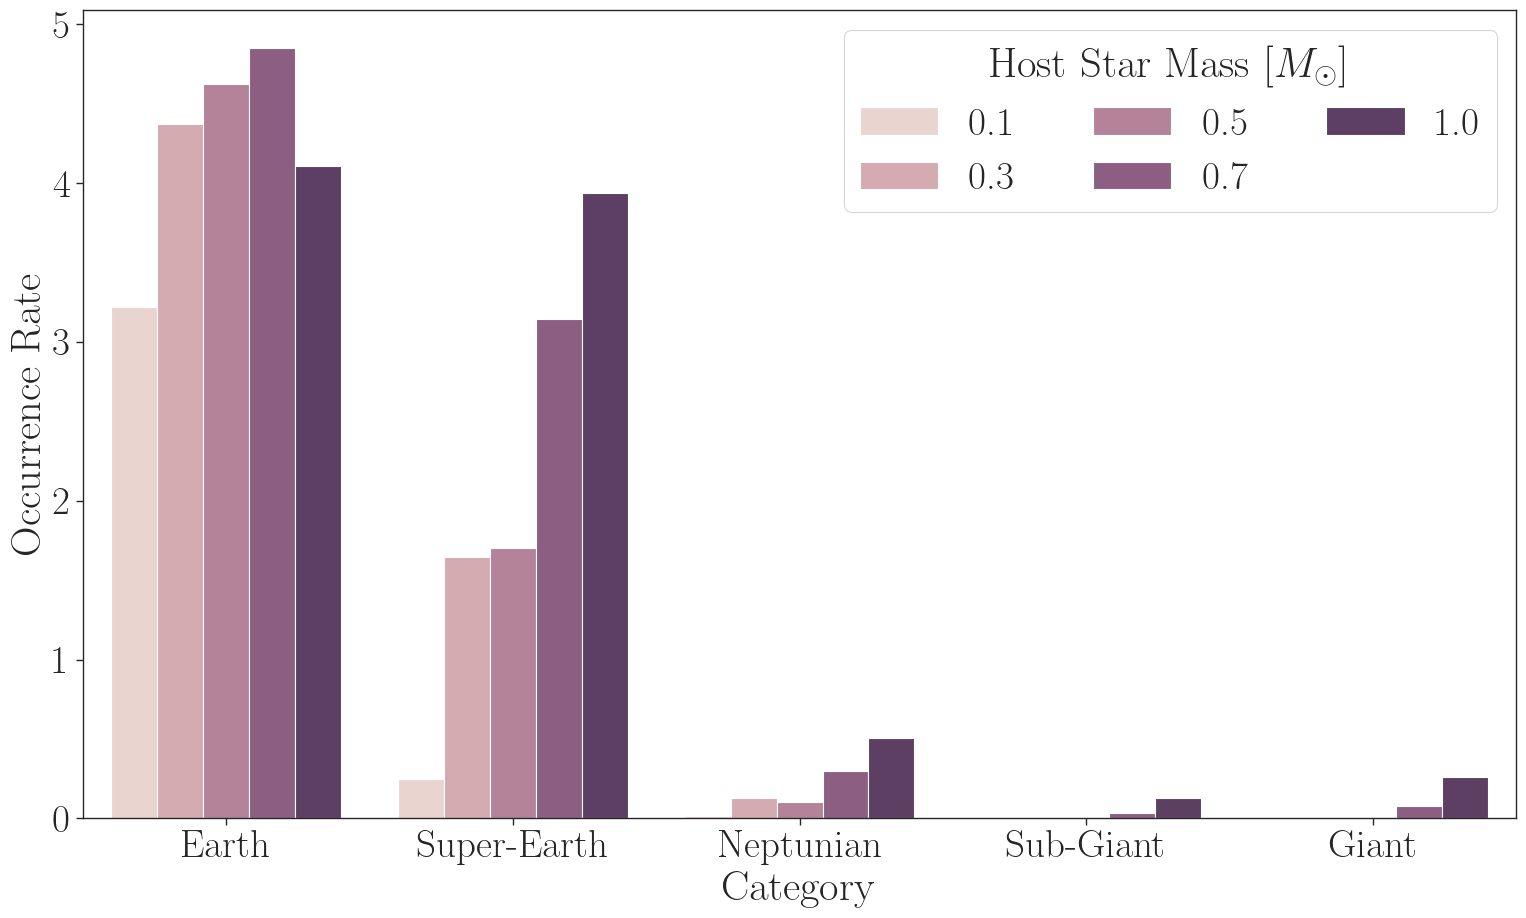

In [49]:
with sns.axes_style("ticks"):
    host_star_mass_plot = sns.barplot(
        data=results_stellar_mass_long_format,
        x="Category",
        y="Occurrence Rate",
        hue=r"Host Star Mass [$M_\odot$]",
        palette=get_palette(),
    )
# adjust legend
host_star_mass_plot = adjust_legend(
    host_star_mass_plot,
    pad=1,
    title="Host Star Mass [$M_\odot$]",
)

FigureProcessor(host_star_mass_plot.figure).save(
    "host_star_mass.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)